In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import glob
import json
import os
import statsmodels.api as st
from statsmodels.discrete.discrete_model import MNLogit
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Use ./aholovenko_data_preprocessing.ipynb to generate processed data.

# Importing data

In [2]:
df = pd.read_csv('../../data/nsduh_processed_data.csv', index_col=0)
df.shape

(296467, 6)

In [3]:
df.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
0,2010,MARIJUANA,Male,Black,20-21,20
1,2010,MARIJUANA,Female,Hispanic,14-15,15
2,2010,ALCOHOL,Female,White,18-19,18
3,2010,NO_DRUG_USE,Male,Hispanic,12-13,13
4,2010,OTHER_TABACCO,Male,Hispanic,20-21,20


In [519]:
df.dtypes

YEAR         int8
CLASS        int8
SEX          int8
RACE         int8
AGE_GROUP    int8
dtype: object

# Reproduce Figure 1

Figure 1: Percent of youth aged 12–21-years whose first drug use was marijuana, cigarettes, alcohol, other tobacco, other drugs, or no drug use by demographic characteristics and survey year. 

Abbreviations: American Indian/Alaska Native (AI/AN); Native Hawaiian and other Pacific Islander (NHOPI).

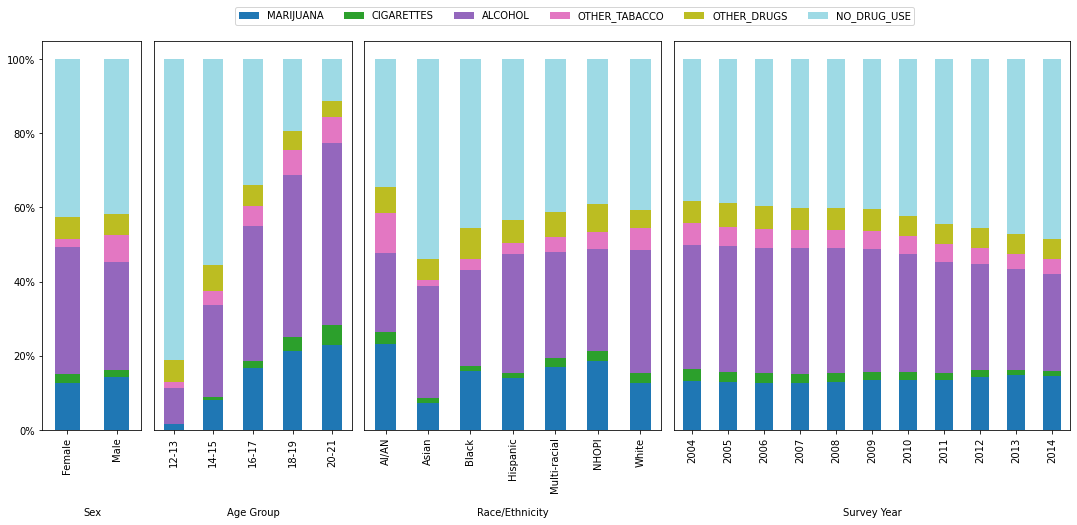

In [520]:
def plot_figure(df_):
    cols = ['MARIJUANA', 'CIGARETTES', 'ALCOHOL', 'OTHER_TABACCO', 'OTHER_DRUGS', 'NO_DRUG_USE']
    prop_sex = pd.crosstab(index=df_['SEX'], columns=df_['CLASS'], normalize="index") * 100
    prop_race = pd.crosstab(index=df_['RACE'], columns=df_['CLASS'], normalize="index") * 100
    prop_age = pd.crosstab(index=df_['AGE_GROUP'], columns=df_['CLASS'], normalize="index") * 100
    prop_year = pd.crosstab(index=df_['YEAR'], columns=df_['CLASS'], normalize="index") * 100
    figure, axis = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 2, 3, 4]})
    figure.set_size_inches(15, 6, forward=True)
    figure.tight_layout() 
    prop_sex[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[0], legend=None, xlabel='Sex')
    prop_age[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[1], legend=None, xlabel='Age Group')
    prop_race[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[2], legend=None, xlabel='Race/Ethnicity')
    prop_year[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[3], legend=None, xlabel='Survey Year')
    axis[0].yaxis.set_major_formatter('{x:1.0f}%')
    axis[1].set_yticks([])
    axis[2].set_yticks([])
    axis[3].set_yticks([])
    axis[0].xaxis.set_label_coords(.5, -.2)
    axis[1].xaxis.set_label_coords(.5, -.2)
    axis[2].xaxis.set_label_coords(.5, -.2)
    axis[3].xaxis.set_label_coords(.5, -.2)
    plt.subplots_adjust(wspace=0.05)
    plt.legend(loc='upper center', bbox_to_anchor=(-0.25, 1.1),  ncol = 6)
    # plt.savefig('figure_1.png', facecolor='white', transparent=False, bbox_inches='tight', pad_inches=.5)
    plt.show()
    
plot_figure(df)

# Reproduce Table 1

Table 1: Demographic and survey characteristics associated with using marijuana as the first drug used relative to no drug use, using cigarettes first, or using alcohol first (n=275,559), adjusted relative risk ratios (aRRR).

In [703]:
class_mapping = {
    'MARIJUANA': 0,
    'ALCOHOL': 1,
    'CIGARETTES': 2,
    'NO_DRUG_USE': 3,
    'OTHER_TABACCO': 4,
    'OTHER_DRUGS': 5
}

In [704]:
data = df.copy()
data['CLASS'] = data.CLASS.map(class_mapping)
data['AGE'] = data.AGE.astype(np.int32)
data['YEAR'] = data.YEAR.astype(np.int32)
data.dtypes

YEAR          int32
CLASS         int64
SEX          object
RACE         object
AGE_GROUP    object
AGE           int32
dtype: object

In [705]:
data.shape

(296467, 6)

In [706]:
data.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
0,2010,0,Male,Black,20-21,20
1,2010,0,Female,Hispanic,14-15,15
2,2010,1,Female,White,18-19,18
3,2010,3,Male,Hispanic,12-13,13
4,2010,4,Male,Hispanic,20-21,20


In [745]:
model = sm.MNLogit.from_formula(
    'CLASS ~ C(SEX, Treatment(reference="Male")) + AGE + C(RACE, Treatment(reference="White")) + YEAR',
    data=data)

In [746]:
log_reg = model.fit(method='newton', maxiter=100, full_output=True)

Optimization terminated successfully.
         Current function value: 1.213960
         Iterations 8


In [795]:
print(log_reg.summary2())

                                             Results: MNLogit
Model:                            MNLogit                       Pseudo R-squared:              0.128      
Dependent Variable:               CLASS                         AIC:                           719897.8895
Date:                             2022-07-19 20:44              BIC:                           720427.8741
No. Observations:                 296467                        Log-Likelihood:                -3.5990e+05
Df Model:                         45                            LL-Null:                       -4.1263e+05
Df Residuals:                     296417                        LLR p-value:                   0.0000     
Converged:                        1.0000                        Scale:                         1.0000     
No. Iterations:                   8.0000                                                                  
----------------------------------------------------------------------------------

In [794]:
dfs = []
lower_CI = log_reg.conf_int()['lower']
upper_CI = log_reg.conf_int()['upper']
for indx in [0, 1, 2]:
    dfs.append(
        pd.DataFrame(
            {
                "aOR": np.exp(log_reg.params[indx]),
                "Lower CI": np.exp(lower_CI.iloc[lower_CI.index.get_level_values('CLASS') == str(indx + 1)].values),
                "Higher CI": np.exp(upper_CI.iloc[upper_CI.index.get_level_values('CLASS') == str(indx + 1)].values),
                "pvalue": log_reg.pvalues[indx],
            }
        )
    )

aOR = pd.concat(dfs, axis=1)
aOR = aOR.drop('Intercept')
aOR.index = [x[-1].replace(')', '').replace('T.', '').replace('"', '').replace('[', ' vs. ').replace(']', '') for x in aOR.index.str.split('reference=')]
aOR = round(aOR, 3)
aOR

,aOR,Lower CI,Higher CI,pvalue,aOR,Lower CI,Higher CI,pvalue,aOR,Lower CI,Higher CI,pvalue
Male vs. Female,1.334,1.303,1.366,0.0,1.476,1.399,1.556,0.000,1.241,1.211,1.273,0.000
White vs. AI/AN,0.341,0.313,0.373,0.0,0.634,0.532,0.756,0.000,0.399,0.365,0.436,0.000
White vs. Asian,1.676,1.544,1.820,0.0,0.787,0.651,0.950,0.013,3.345,3.075,3.638,0.000
White vs. Black,0.623,0.601,0.645,0.0,0.344,0.312,0.379,0.000,0.992,0.958,1.028,0.668
White vs. Hispanic,0.871,0.844,0.899,0.0,0.417,0.382,0.454,0.000,0.974,0.942,1.007,0.118
White vs. Multi-racial,0.626,0.591,0.663,0.0,0.707,0.622,0.804,0.000,0.617,0.581,0.655,0.000
White vs. NHOPI,0.580,0.495,0.679,0.0,0.663,0.471,0.935,0.019,0.733,0.622,0.865,0.000
AGE,0.932,0.927,0.936,0.0,1.146,1.133,1.160,0.000,0.580,0.577,0.583,0.000
YEAR,0.965,0.961,0.969,0.0,0.912,0.904,0.920,0.000,1.028,1.023,1.032,0.000


# Plot Table 2

Table columns
- Heavy Marijuana Use Among Users (n=71,699)
- Cannabis Use Disorder Among Users (n=71,699)
- Alcohol Use Disorder Among Drinkers (n=136,399)
- Nicotine Dependence Among Smokers (n=89,202)
- Other Drug Use *c,d* (n=142,630)
    * *c* Other drugs included non-medical use of cocaine, hallucinogens, heroin, inhalants, analgesics, sedatives, stimulants, and tranquillizers.
    * *d* Those having used only one drug or all five types of drugs dropped from analyses (n=67,148) after controlling for number of drugs used due to no variance in the outcome.

Methodology
- **Heavy marijuana use** was defined as reporting marijuana use on either ≥20 or more days in the past month, or ≥300 days in the past year. **MRJMDAYS**, **MRJYDAYS**
- Participants were classified as having a **cannabis use disorder (CUD)** or **alcohol use disorder (AUD)** if, within the last 12 months, they had met one or more features of abuse or 3 or more features of dependence based on criteria in the Diagnostic and Statistical Manual of Mental Disorders, 4th Edition (American Psychiatric Association, 1994).  -> **DEPNDALC**, **DEPNDMRJ**
- Those whose total score on the Nicotine Dependence Syndrome Scale was ≥2.75 were classified as **having nicotine dependence (ND)** (Shiffman, Waters, & Hickcox, 2004). -> **NDSSDNSP**
- Any lifetime use of other drugs was based on responses to items about having ever used inhalants, cocaine, heroin, and non-medical prescription drugs

In [150]:
df.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,MRJMDAYS,MRJYDAYS,DEPNDALC,DEPNDMRJ,NDSSDNSP
0,2010,MARIJUANA,Male,Black,20-21,5,6,0,0,0
1,2010,MARIJUANA,Female,Hispanic,14-15,5,1,1,0,0
2,2010,ALCOHOL,Female,White,18-19,5,6,0,0,0
3,2010,NO_DRUG_USE,Male,Hispanic,12-13,5,6,0,0,0
4,2010,OTHER_TABACCO,Male,Hispanic,20-21,3,4,1,0,0


In [152]:
df[(df.CLASS!='NO_DRUG_USE')].shape

(171315, 10)

In [135]:
df.shape

(55268, 30)

__________